In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from IPython.core import debugger
debug = debugger.Pdb().set_trace

%matplotlib inline


# 训练给定数据集，并测试和可视化结果。


# 鸢尾花(iris)数据集
# 数据集内包含 3 类共 150 条记录，每类各 50 个数据，
# 每条记录都有 4 项特征：花萼长度、花萼宽度、花瓣长度、花瓣宽度，
# 可以通过这4个特征预测鸢尾花卉属于（iris-setosa, iris-versicolour, iris-virginica）中的哪一品种。
# 这里只取前100条记录，两项特征，两个类别。
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]


X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)



class SVM(object):

    def __init__(self, kernel='linear', epsilon=0.001, C=1, Max_Interation=5000):
        self.kernel = kernel
        self.epsilon = epsilon
        self.C = C
        self.Max_Interation = Max_Interation

    def _init_parameters(self, features, labels):
        # 参数初始化
        self.X = features
        self.Y = labels

        self.b = 0.0
        self.n = len(features[0])
        self.N = len(features)
        self.alpha = [0.0] * self.N
        self.E = [self._E_(i) for i in range(self.N)]

    #kkt条件
    def _satisfy_KKT(self, i):
        ygx = self.Y[i] * self._g_(i)
        if abs(self.alpha[i])<self.epsilon:
            return ygx >= 1
        elif abs(self.alpha[i]-self.C)<self.epsilon:
            return ygx <= 1
        else:
            return abs(ygx-1) < self.epsilon

    #停止条件
    def is_stop(self):
        for i in range(self.N):
            satisfy = self._satisfy_KKT(i)
            if not satisfy:
                return False
        return True

    def _select_two_parameters(self):
        # 选择两个变量
        index_list = [i for i in range(self.N)]

        i1_list_1 = list(filter(lambda i: self.alpha[i] > 0 and self.alpha[i] < self.C, index_list))
        i1_list_2 = list(set(index_list) - set(i1_list_1))

        i1_list = i1_list_1
        i1_list.extend(i1_list_2)

        for i in i1_list:
            if self._satisfy_KKT(i):
                continue

            E1 = self.E[i]
            max_ = (0, 0)

            for j in index_list:
                if i == j:
                    continue

                E2 = self.E[j]
                if abs(E1 - E2) > max_[0]:
                    max_ = (abs(E1 - E2), j)
            return i, max_[1]

    def _K_(self, x1, x2):
        # 核函数
        if self.kernel == 'linear':
            return sum([x1[k] * x2[k] for k in range(self.n)])
        if self.kernel == 'poly':
            return (sum([x1[k] * x2[k] for k in range(self.n)])+1)**3
        print('没有定义核函数')
        return 0

    def _g_(self, i):
        # g(X[i])
        result = self.b

        for j in range(self.N):
            result += self.alpha[j] * self.Y[j] * self._K_(self.X[i], self.X[j])
        return result

    def _E_(self, i):
        # E(i)
        return self._g_(i) - self.Y[i]
    
    def clip_LH(self, _alpha, L, H):
        if _alpha > H:
            return H
        elif _alpha < L:
            return L
        else:
            return _alpha  
        
    def thresh_LH(self, i1, i2):
        if self.Y[i1] == self.Y[i2]:
            L = max(0, self.alpha[i2] + self.alpha[i1] - self.C)
            H = min(self.C, self.alpha[i2] + self.alpha[i1])
        else:
            L = max(0, self.alpha[i2] - self.alpha[i1])
            H = min(self.C, self.C + self.alpha[i2] - self.alpha[i1])
        return L, H


    def train(self, features, labels):

        self._init_parameters(features, labels)

        for times in range(self.Max_Interation):

            # 启发式的选取两个样本index。
            i1, i2 = self._select_two_parameters()
            
            eta = self._K_(self.X[i1], self.X[i1]) + self._K_(self.X[i2], self.X[i2]) - 2 * self._K_(self.X[i1], self.X[i2]) 

            alpha2_new_unc =  self.alpha[i2] + self.Y[i2] * (self.E[i1] - self.E[i2]) / eta  # ???   a2_new_unc 如何计算
            
            L,H = self.thresh_LH(i1,i2)
            
            alpha2_new = self.clip_LH(alpha2_new_unc, L, H)   # ??? 剪切到合法区间  
            
            alpha1_new = self.alpha[i1] + self.Y[i1] * self.Y[i2] * (self.alpha[i2] - alpha2_new) # ??? 根据a1y1+a2y2=sigma，得到a1_new。

            b1_new = -self.E[i1] - self.Y[i1] * self._K_(self.X[i1], self.X[i1]) * (alpha1_new - self.alpha[i1]) - self.Y[i2] * self._K_(self.X[i2], self.X[i1]) * (alpha2_new - self.alpha[i2]) + self.b    # ??? 根据a1计算的b1
            b2_new = -self.E[i2] - self.Y[i1] * self._K_(self.X[i1], self.X[i2]) * (alpha1_new - self.alpha[i1]) - self.Y[i2] * self._K_(self.X[i2], self.X[i2]) * (alpha2_new - self.alpha[i2]) + self.b    # ??? 根据a2计算的b1

            if alpha1_new > 0 and alpha1_new < self.C:
                b_new = b1_new
            elif alpha2_new > 0 and alpha2_new < self.C:
                b_new = b2_new
            else:
                b_new = (b1_new + b2_new) / 2

            # 更新a、b和E 
            self.alpha[i1] = alpha1_new
            self.alpha[i2] = alpha2_new
            self.b = b_new

            self.E[i1] = self._E_(i1)
            self.E[i2] = self._E_(i2)
        # print([int(i) for i in self.alpha])
        return 'train done!'

    def _predict_(self,feature):
        result = self.b

        for i in range(self.N):
            result += self.alpha[i]*self.Y[i]*self._K_(feature,self.X[i])

        if result > 0:
            return 1
        return -1

    def predict(self,features):
        results = []

        for feature in features:
            results.append(self._predict_(feature))

        return results

svm = SVM()
svm.train(X_train, y_train)
test_predict = svm.predict(X_test)
score = accuracy_score(y_test,test_predict)
print('测试集准确率：',score) # 测试集准确率


c:\users\lenovo\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:151: RuntimeWarning: divide by zero encountered in double_scalars


测试集准确率： 1.0


## 可视化以上优化好的分类超平面和间隔界面，把支持向量也标注进来。

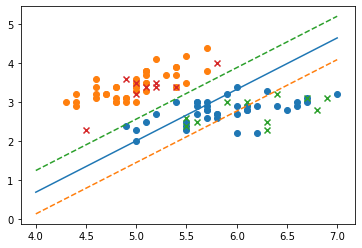

In [2]:
# 可视化以上优化好的分类超平面和间隔界面，把支持向量也标注来。

x = np.linspace(4, 7)
b = svm.b
w = 0

for i in range(svm.N):
    w += svm.alpha[i] * svm.Y[i] * svm.X[i]      #y = w1x1 + w2x2 + b

y = (-b-w[0]*x)/w[1]         #y=0时位于超平面上
y_low = (-1-b-w[0]*x)/w[1]     #y=-1时位于下间隔边界
y_up = (1-b-w[0]*x)/w[1]       #y=1时位于上间隔边界

plt.plot(x,y,'-')
plt.plot(x,y_up,'--')
plt.plot(x,y_low,'--')
plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], marker='o', label='1')
plt.scatter(X_train[y_train==-1,0], X_train[y_train==-1,1], marker='o', label='-1')
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], marker='x')
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], marker='x')

## 标注支持向量

测试集准确率： 1.0


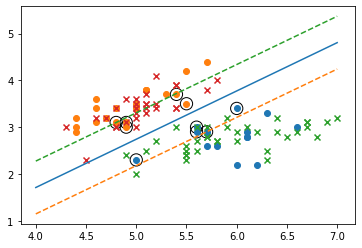

In [3]:
# 标注支持向量。

import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


#获取数据函数   
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

X, y = create_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.65, random_state=65)

svm_sk = SVC(kernel='linear',C=1,shrinking=True,max_iter=5000)
svm_sk.fit(X_train, y_train)
test_predict = svm_sk.predict(X_test)
score = accuracy_score(y_test,test_predict)
print('测试集准确率：',score) # 测试集准确率

w = svm_sk.coef_[0]  
b = svm_sk.intercept_[0]  

x2 = np.linspace(4, 7)   #y = w1x1 + w2x2 + b
y2 = (-b-w[0]*x2)/w[1]     #y=0时位于超平面上
y2_low = (-1-b-w[0]*x2)/w[1]     #y=-1时位于下间隔边界
y2_up = (1-b-w[0]*x2)/w[1]       #y=1时位于上间隔边界
plt.plot(x2,y2,'-')
plt.plot(x2,y2_up,'--')
plt.plot(x2,y2_low,'--')

#画出支持向量点
plt.scatter(svm_sk.support_vectors_[:,0], svm_sk.support_vectors_[:,1],
s=150,facecolors = 'none', edgecolors='k')

plt.scatter(X_train[y_train==1,0], X_train[y_train==1,1], marker='o', label='1')
plt.scatter(X_train[y_train==-1,0], X_train[y_train==-1,1], marker='o', label='-1')
plt.scatter(X_test[y_test==1,0], X_test[y_test==1,1], marker='x')
plt.scatter(X_test[y_test==-1,0], X_test[y_test==-1,1], marker='x')

# 绘制平面图
plt.axis('tight')
plt.show()